In [10]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'
import mne
from mne.preprocessing import ICA
from mne_bids import BIDSPath, read_raw_bids

In [11]:
meta_data = np.load('../data/things-eeg2_preproc/image_metadata.npy',allow_pickle=True).item()
file_names = np.array(meta_data['test_img_files'])

In [12]:
eeg_data_train = np.load('../data/thingseeg2_fullpreproc/sub-01/preprocessed_eeg_training.npy', allow_pickle=True).item()
eeg_data_test = np.load('../data/thingseeg2_fullpreproc/sub-01/preprocessed_eeg_test.npy', allow_pickle=True).item()
train_thingseeg2_avg = eeg_data_train['preprocessed_eeg_data'].mean(1)[:,:,20:] * 1e-6
test_thingseeg2_avg = eeg_data_test['preprocessed_eeg_data'].mean(1)[:,:,20:] * 1e-6

print('Training EEG data shape:')
print(eeg_data_train['preprocessed_eeg_data'].shape)
print('(Training image conditions × Training EEG repetitions × EEG channels × '
    'EEG time points)')

print('\nTest EEG data shape:')
print(eeg_data_test['preprocessed_eeg_data'].shape)
print('(Test image conditions × Test EEG repetitions × EEG channels × '
    'EEG time points)')

Training EEG data shape:
(16540, 4, 63, 100)
(Training image conditions × Training EEG repetitions × EEG channels × EEG time points)

Test EEG data shape:
(200, 80, 63, 100)
(Test image conditions × Test EEG repetitions × EEG channels × EEG time points)


In [16]:
mne_info = mne.create_info(eeg_data_test['ch_names'], 100, 'eeg')
test_epochs = mne.EpochsArray(test_thingseeg2_avg, mne_info)

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


In [17]:
data_dir = '../data/thingseeg2/raw_bids/'
eeg_path = BIDSPath(
        subject='01',
        session='01',
        task='test',
        root=data_dir,
        datatype="eeg",
    )
raw = read_raw_bids(eeg_path, verbose='ERROR')

In [18]:
# ch_pos = dict([item for item in raw.get_montage().get_positions()['ch_pos'].items() if item[0] in eeg_data_test['ch_names']])
# dig_montage = mne.channels.make_dig_montage(ch_pos=ch_pos, nasion=raw.get_montage().get_positions()['nasion'], lpa=raw.get_montage().get_positions()['lpa'], rpa=raw.get_montage().get_positions()['rpa'])
# test_epochs.set_montage(dig_montage)
test_epochs.set_montage(raw.get_montage())

<EpochsArray |  200 events (all good), 0 – 0.79 s, baseline off, ~7.8 MB, data loaded,
 '1': 200>

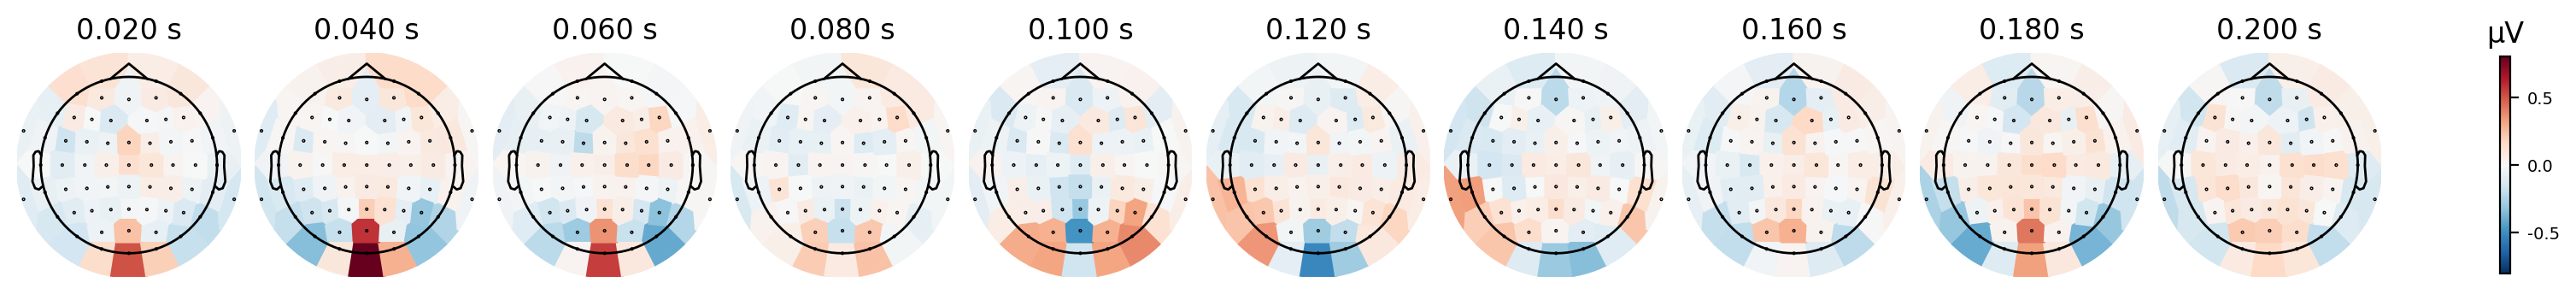

In [19]:
test_epochs[7].average().plot_topomap(times=[0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2], extrapolate='head', show=True, image_interp='nearest', contours=0);

In [20]:
# create ica instance with defined parameters
ica = ICA(0.999999, # number of components to extract. Here we use .95 meaning...
          # ...'as many as necessary to account for 95% of data variance...
          # in a preliminary PCA'
          max_iter= 1000, # max iterations allowed for the algorithm
          random_state=1, # this is just so you can replicate my results
          method = 'infomax', # algorithm used
          fit_params=dict(extended = True) # algorithm-specific parameters ...
         )                               #...(in this case 'use extended infomax')

In [21]:
# fit ica with the parameters above to the data
ica.fit(test_epochs, # data
        picks = 'eeg', # channels to use
        # reject = dict(eeg = 300e-6) # threshold to ignore parts of the signal
       )

Fitting ICA to data using 63 channels (please be patient, this may take a while)


/tmp/ipykernel_3770795/1168566631.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(test_epochs, # data


Selecting by explained variance: 63 components
Computing Extended Infomax ICA
Fitting ICA took 18.3s.


<ICA | epochs decomposition, method: infomax (fit in 91 iterations on 16000 samples), 63 ICA components (63 PCA components available), channel types: eeg, no sources marked for exclusion>

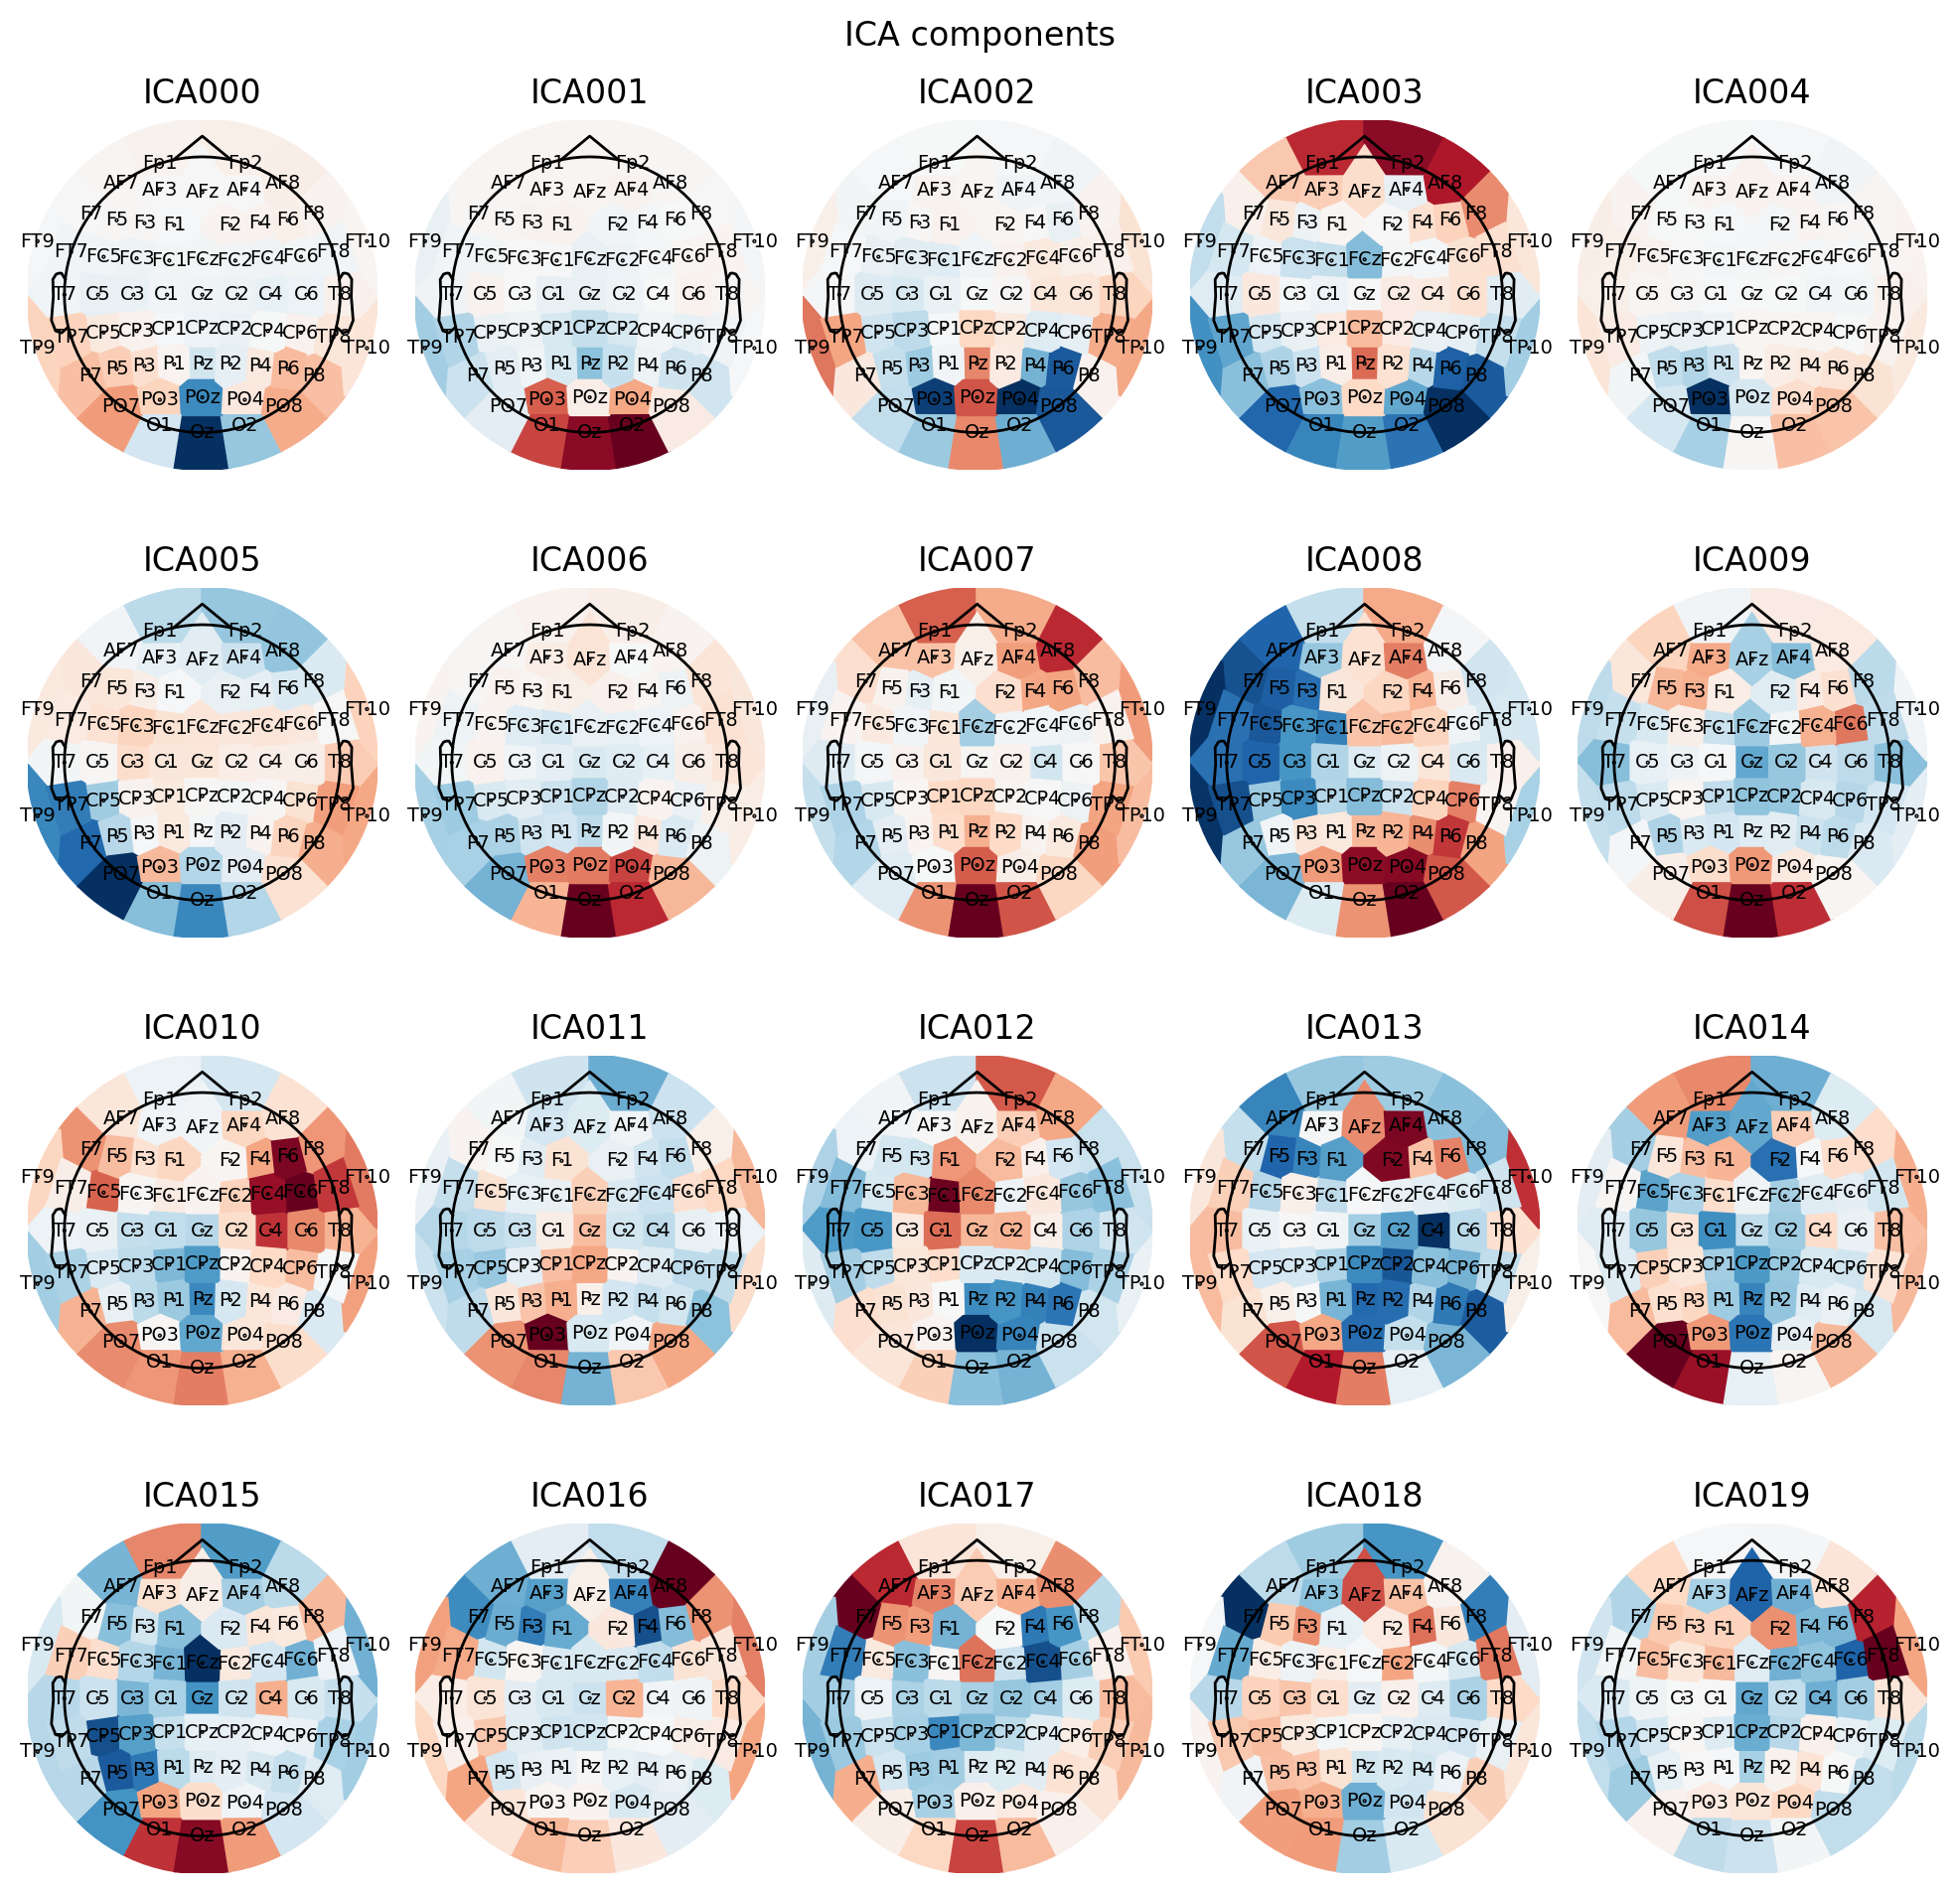

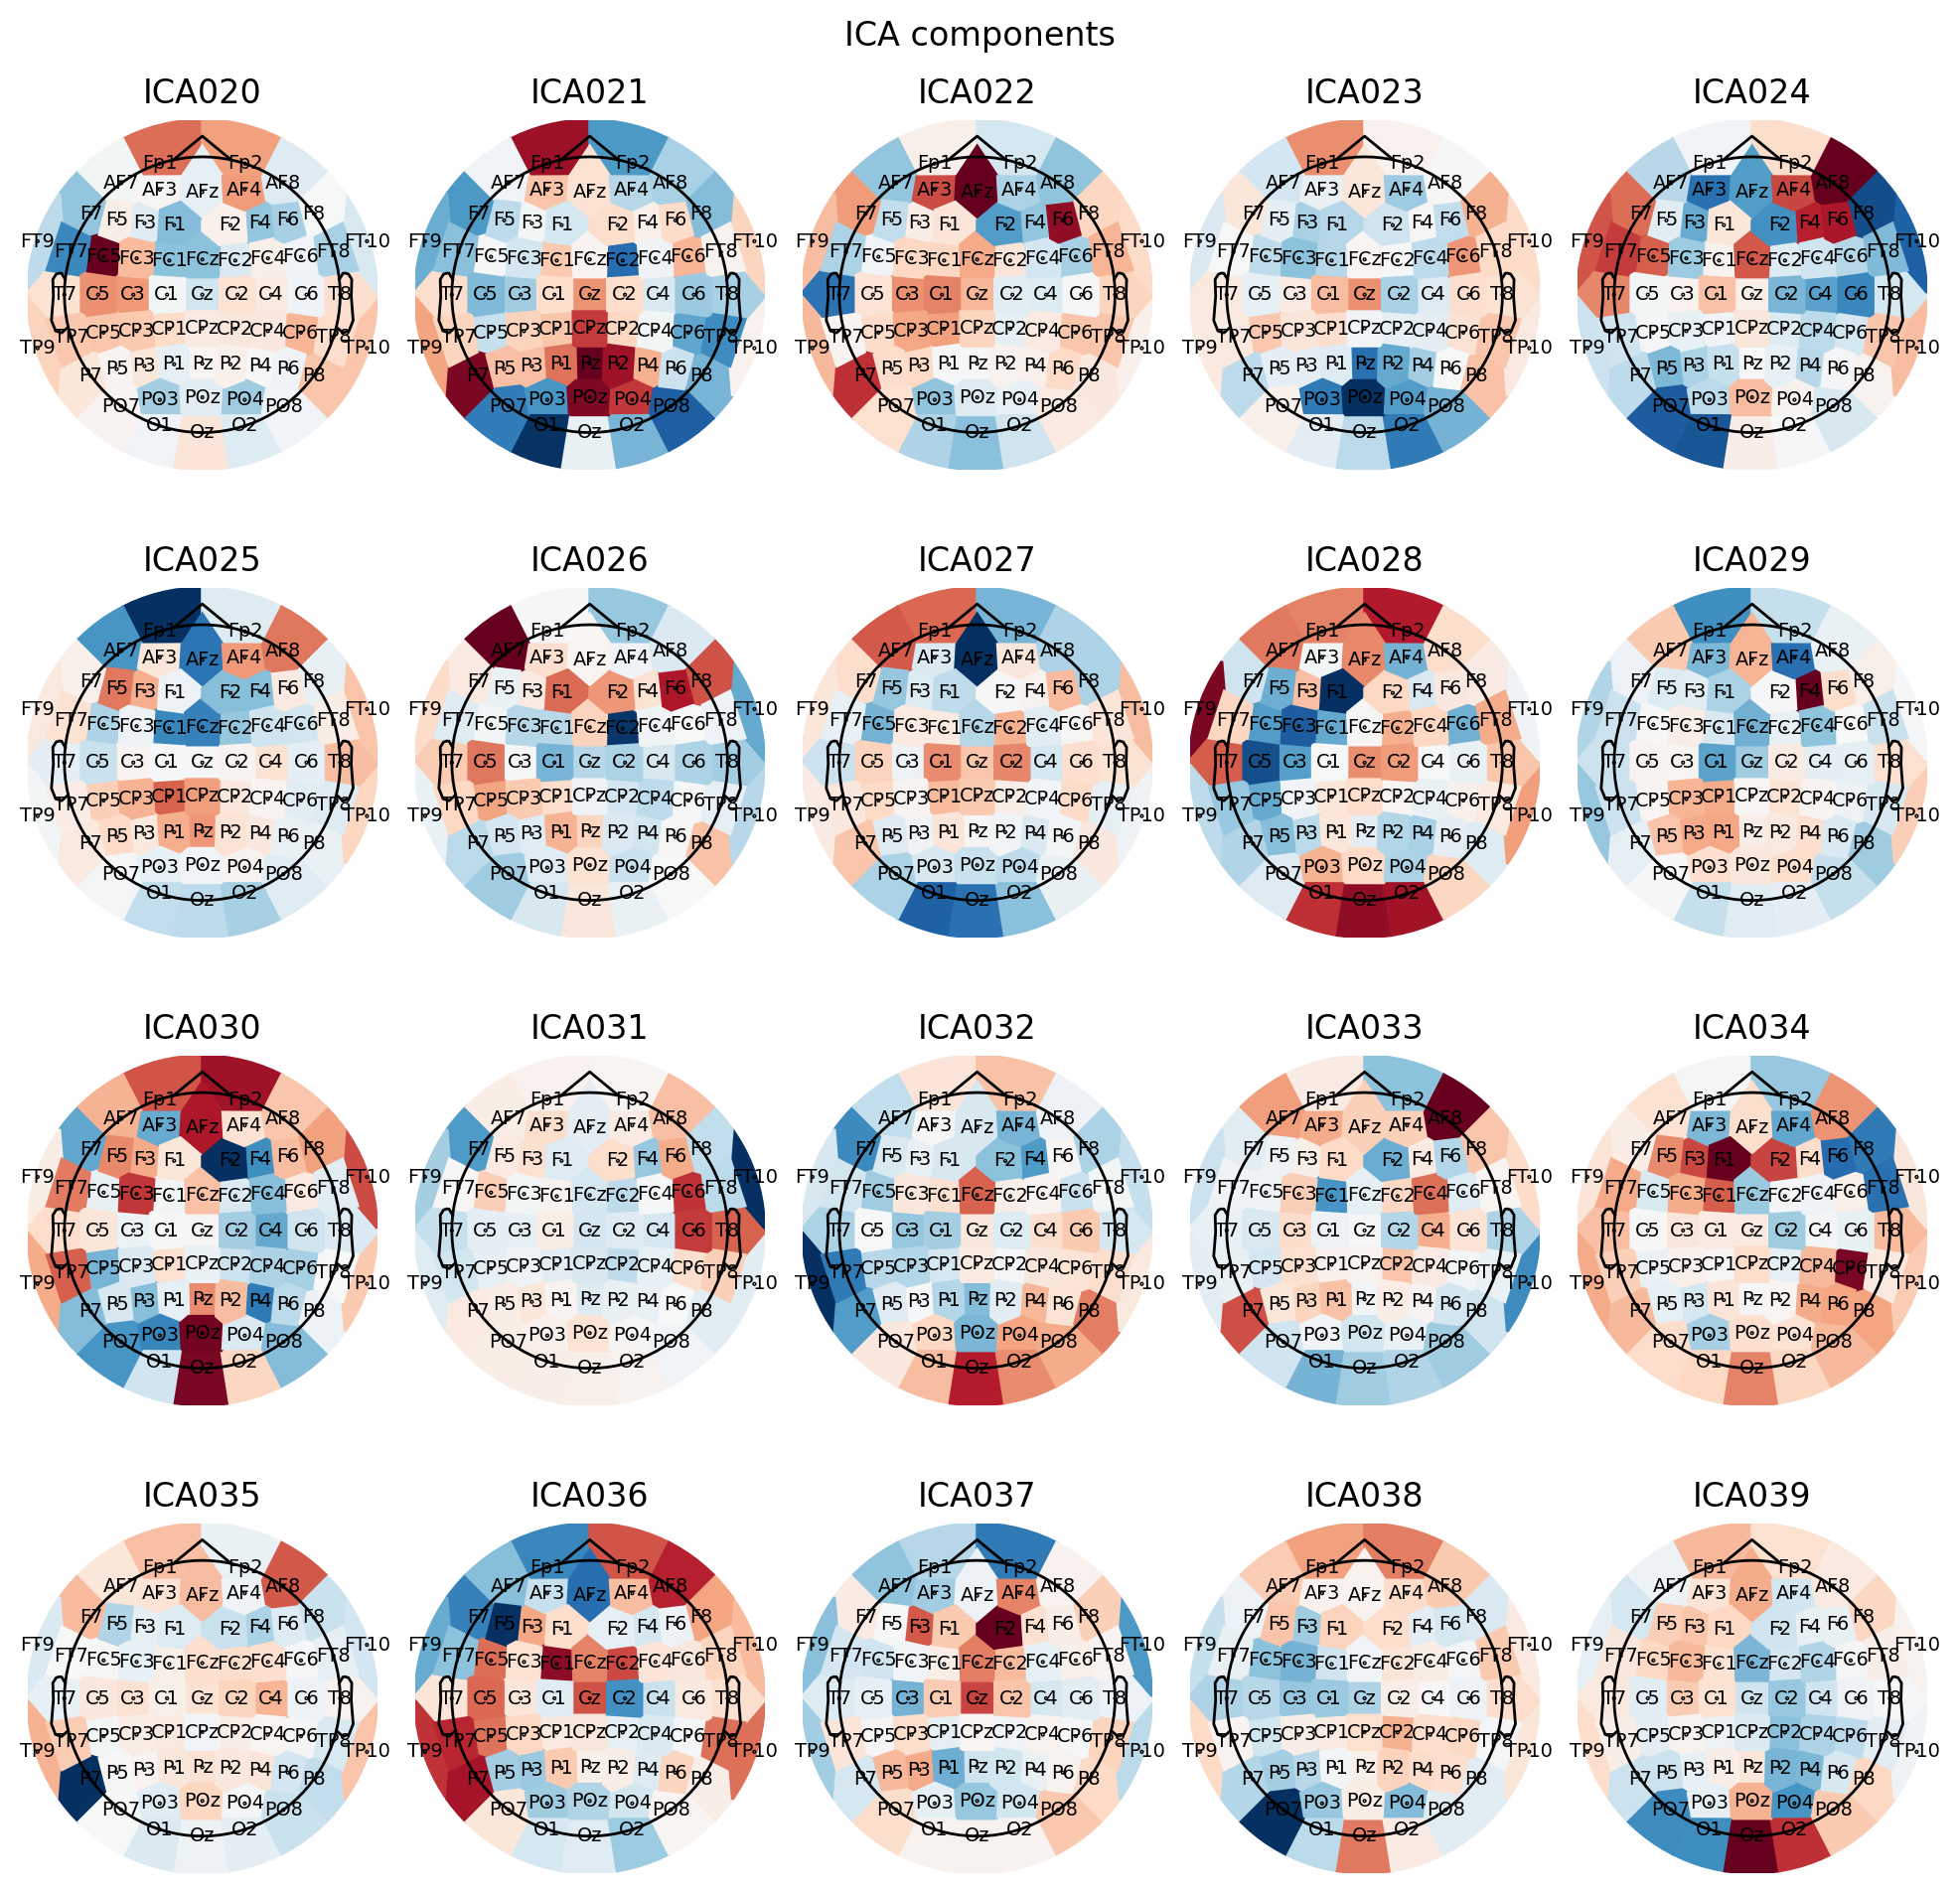

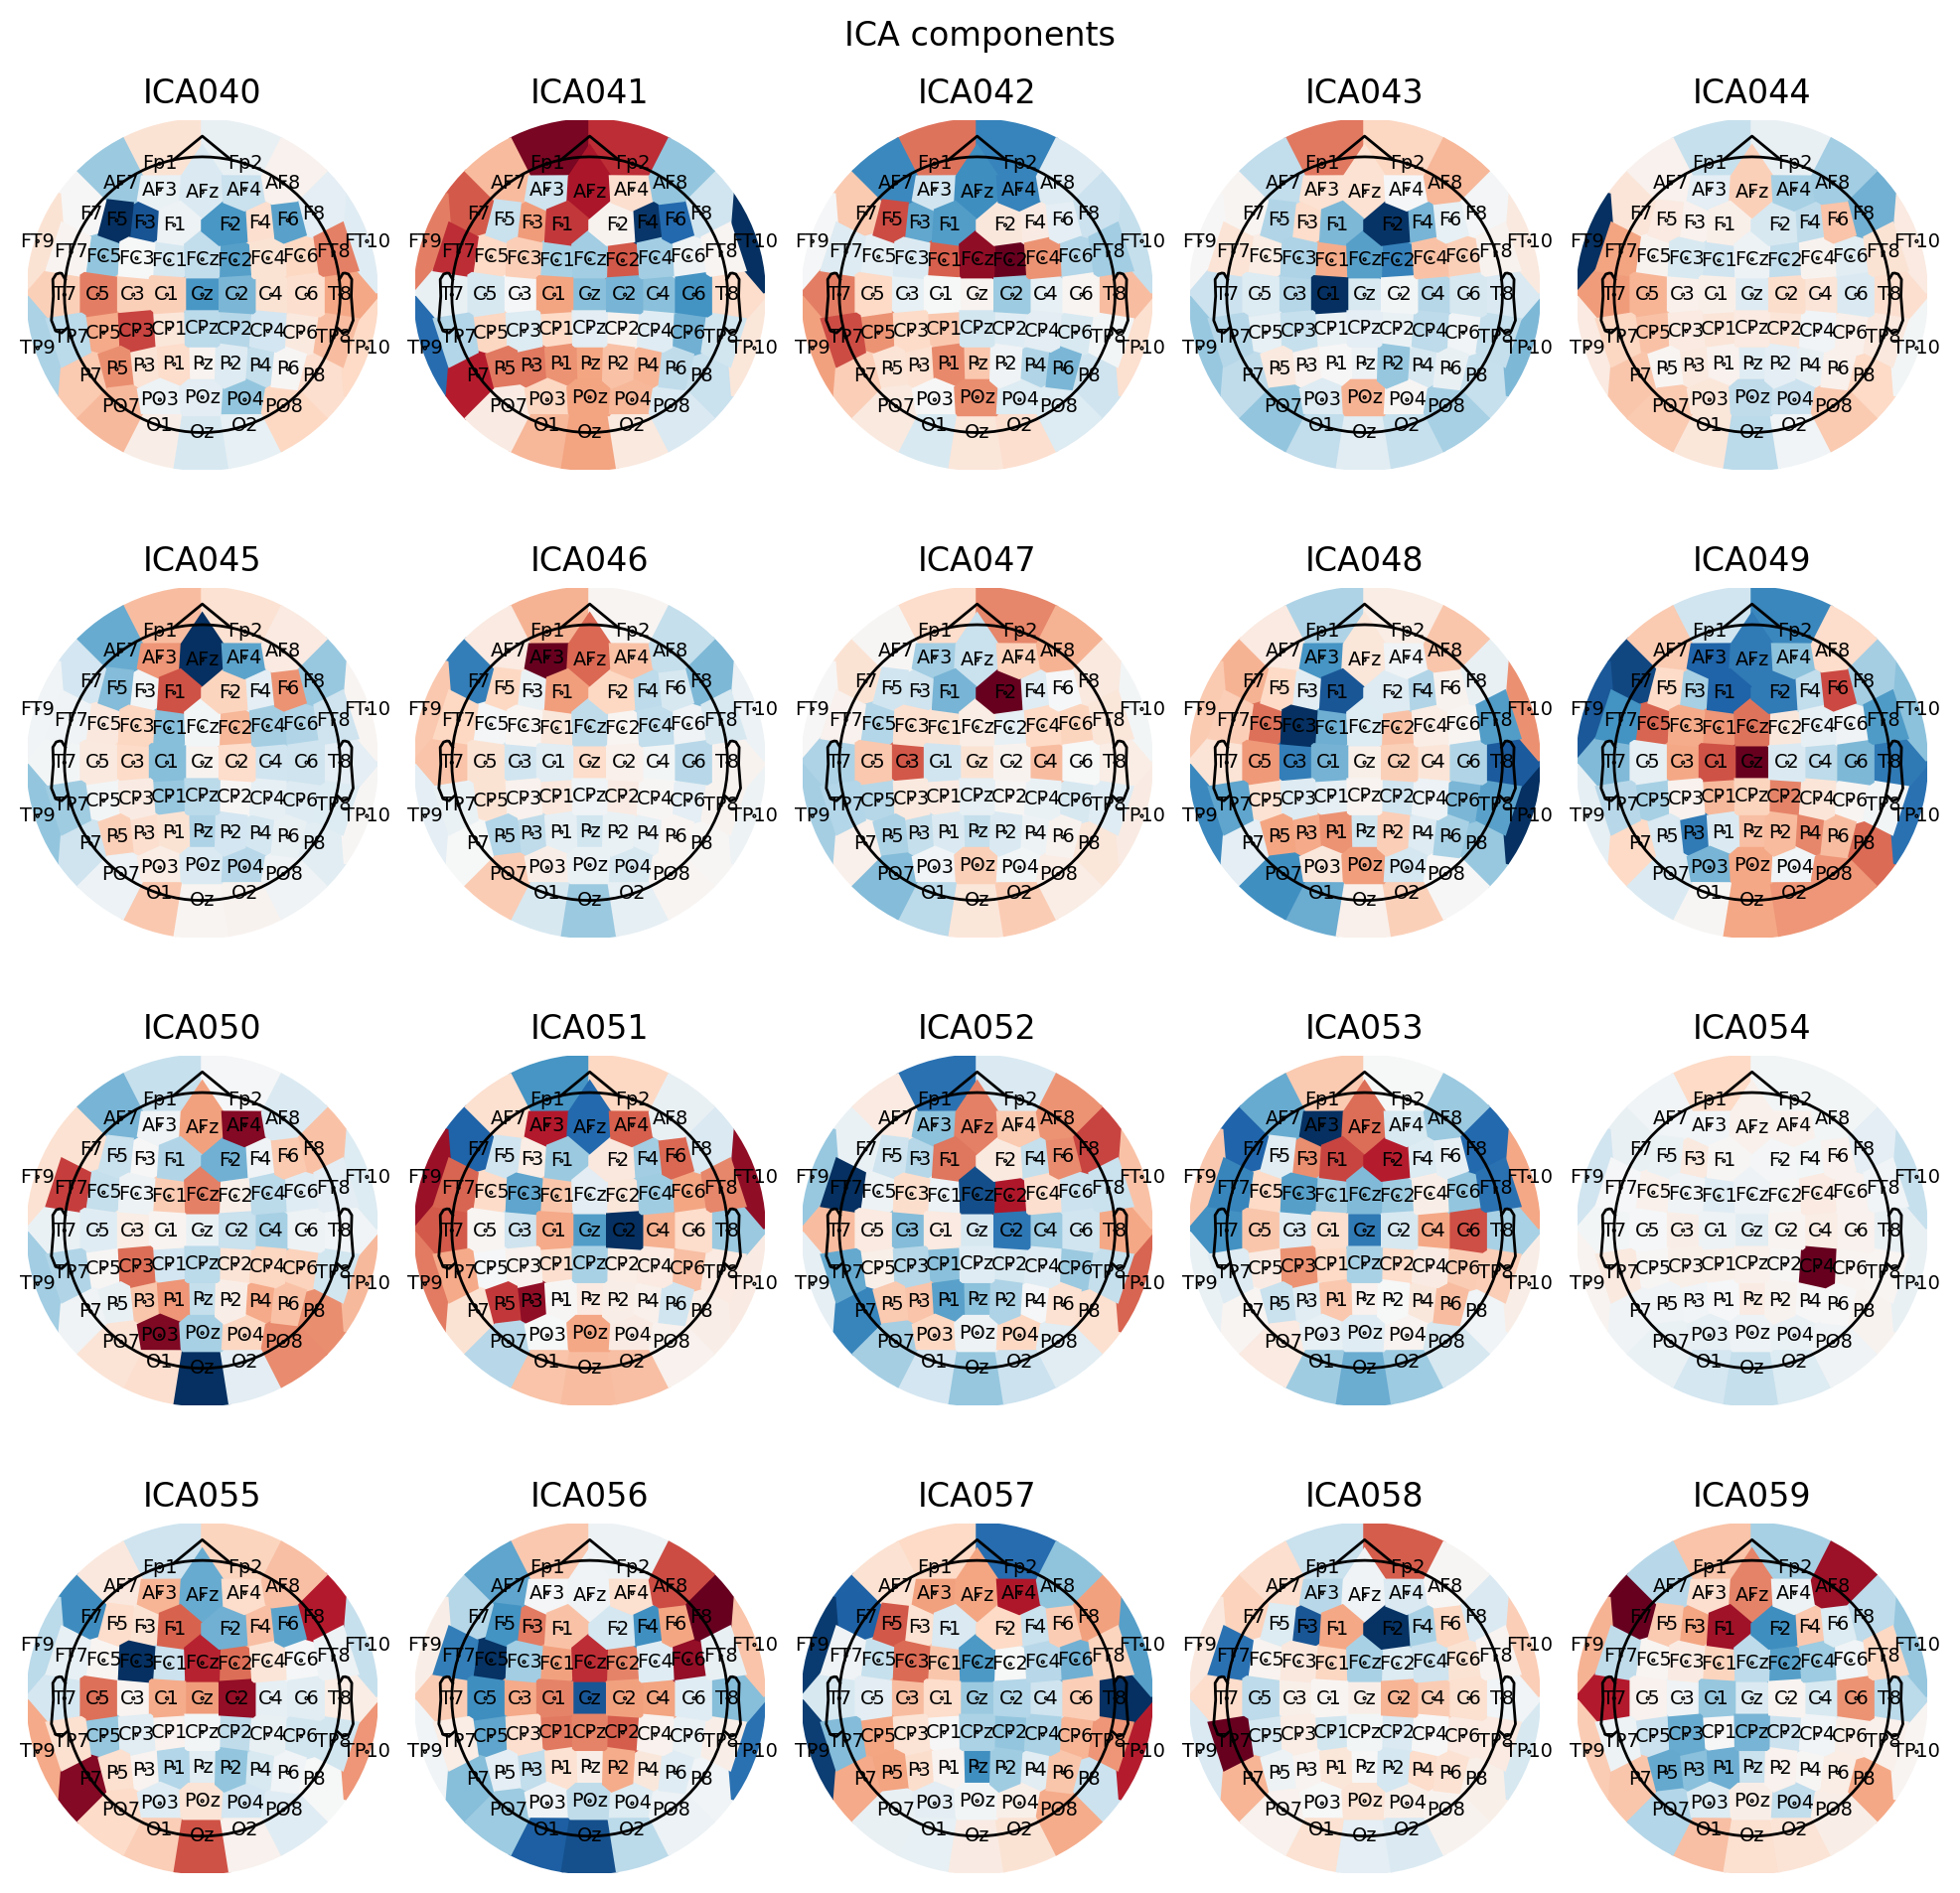

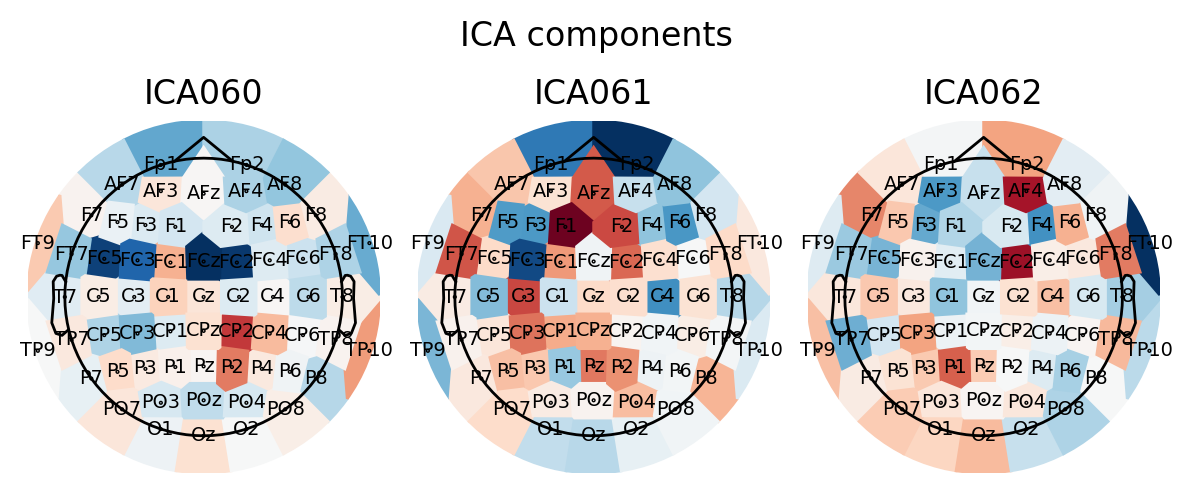

In [22]:
ica.plot_components(image_interp='nearest', contours=0, show_names=True);

    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


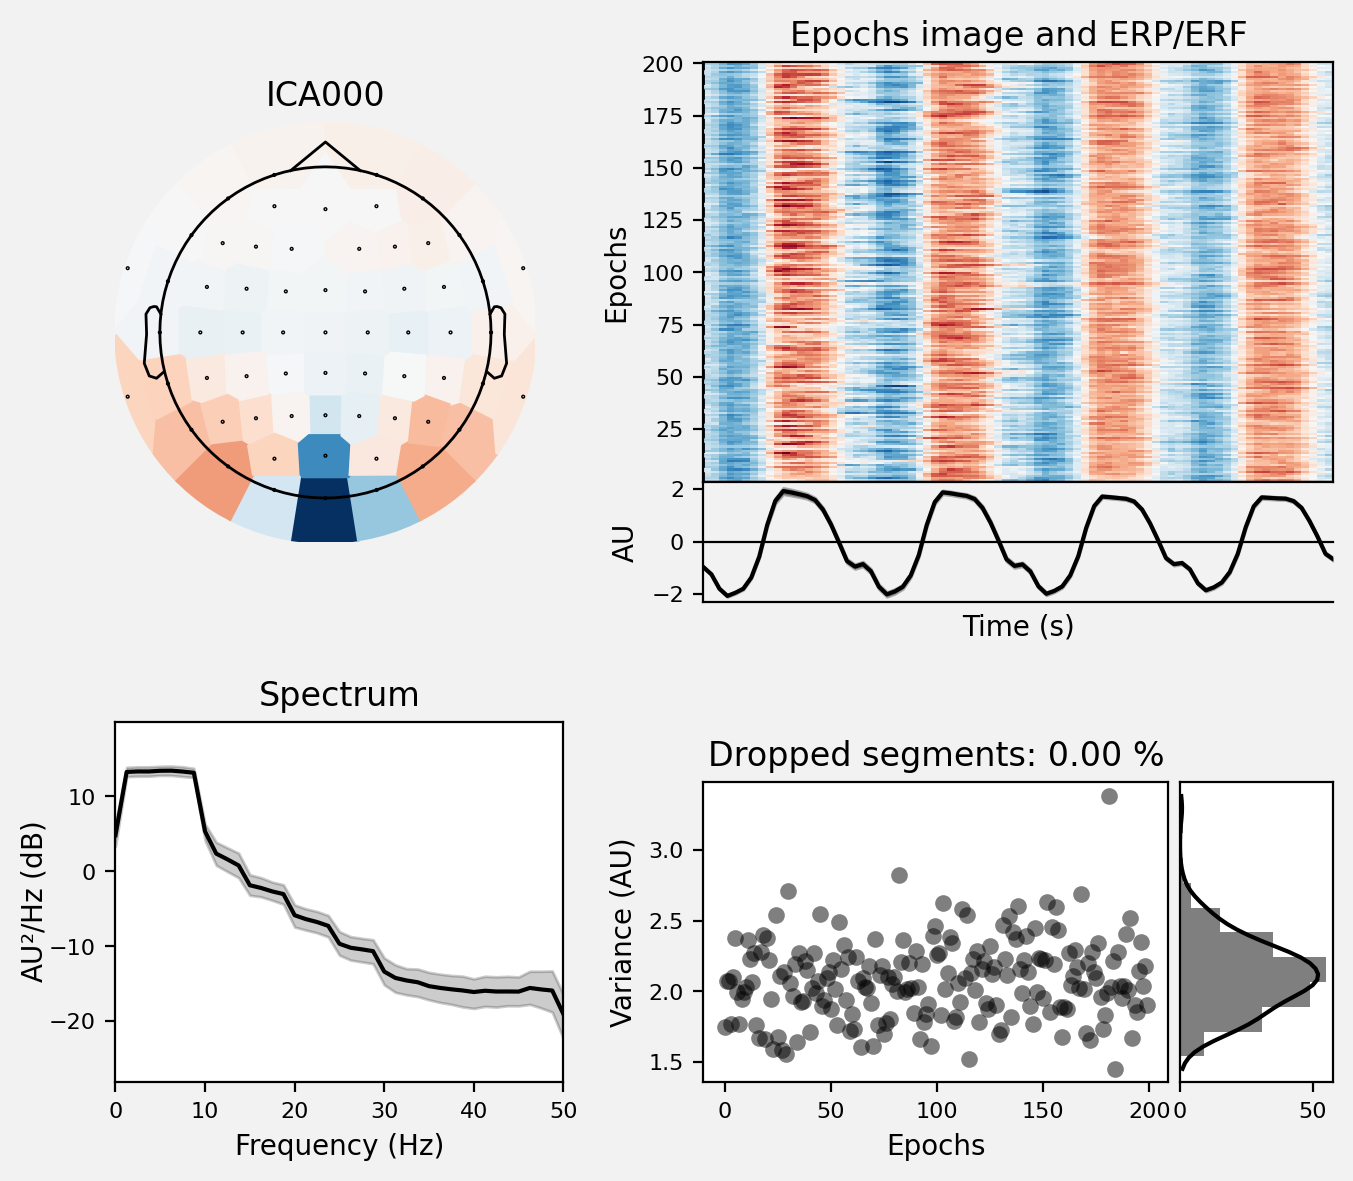

In [27]:
ica.plot_properties(test_epochs, picks=range(0, 1), topomap_args={'image_interp':'nearest','contours':0}, show=True);